Dataset: GunPoint
https://www.timeseriesclassification.com/description.php?Dataset=GunPoint

Goal: Use above time series data set, convert it to image, use Computer Vision Convolutional neural network to predict:  "gun" or "no gun (pointing)"

Aproach: Use Markov Transiotion Field and Gramian angular field for pictorial representation of data 

In [1]:
import torch
from torchvision import transforms
from PIL import Image

from fastai import*
from fastai.imports import*
from fastai.vision import *
from fastai.vision.all import *

In [2]:
# load train and test data
test_path = Path("GunPoint/GunPoint_TEST.txt")
train_path = Path("GunPoint/GunPoint_TRAIN.txt")
train_path, test_path

(Path('GunPoint/GunPoint_TRAIN.txt'), Path('GunPoint/GunPoint_TEST.txt'))

In [3]:
# Convert Test (txt to csv)
raw = open(test_path).readlines() 
raw = [map(float, each.strip().split()) for each in raw] 
df_data = list()
for i in range(len(raw)):
    df_data.append(list(raw[i]))
train_df = pd.DataFrame(df_data)
train_df.head()
train_df.to_csv("GunPoint_Test.csv", index=False)

In [4]:
# Convert  Train (txt to csv)
raw = open(train_path).readlines() 
raw = [map(float, each.strip().split()) for each in raw] 
df_data = list()
for i in range(len(raw)):
    df_data.append(list(raw[i]))
train_df = pd.DataFrame(df_data)
train_df.head()
train_df.to_csv("GunPoint_Train.csv", index=False)

In [5]:
#Load data as pandas 
path_train = Path("GunPoint_Train.csv")
path_test = Path("GunPoint_Test.csv")
df1 = pd.read_csv(path_train)
df2 = pd.read_csv(path_test)

In [6]:
df1.shape, df2.shape

((50, 151), (150, 151))

In [7]:
#Join train and test in one df b4 encription
df = pd.concat([df1, df2], ignore_index=True)
df.shape

(200, 151)

In [8]:
# separate dependent var 
classes = df["0"]
classes.shape

(200,)

In [9]:
df.drop(columns=["0"], inplace=True)
df.head()

,1,2,3,4,5,6,7,8,9,10,...,141,142,143,144,145,146,147,148,149,150
0,-0.647885,-0.641992,-0.638186,-0.638259,-0.638345,-0.638697,-0.643049,-0.643768,-0.645050,-0.647118,...,-0.639264,-0.639716,-0.639735,-0.640184,-0.639235,-0.639395,-0.640231,-0.640429,-0.638666,-0.638657
1,-0.644427,-0.645401,-0.647055,-0.647492,-0.646910,-0.643884,-0.639731,-0.638094,-0.635297,-0.635384,...,-0.641140,-0.641426,-0.639267,-0.637797,-0.637680,-0.635260,-0.635490,-0.634934,-0.634497,-0.631596
2,-0.778353,-0.778279,-0.777151,-0.777684,-0.775900,-0.772421,-0.765464,-0.762275,-0.763752,-0.765356,...,-0.722055,-0.718712,-0.713534,-0.710021,-0.704126,-0.703263,-0.703393,-0.704196,-0.707605,-0.707120
3,-0.750060,-0.748103,-0.746164,-0.745926,-0.743767,-0.743805,-0.745213,-0.745082,-0.745727,-0.745815,...,-0.721667,-0.724661,-0.729229,-0.728940,-0.727834,-0.728244,-0.726453,-0.725517,-0.725191,-0.724679
4,-0.599539,-0.597422,-0.599269,-0.598259,-0.597582,-0.591303,-0.589020,-0.587533,-0.585462,-0.583847,...,-0.644036,-0.643885,-0.645742,-0.646458,-0.646464,-0.645585,-0.642412,-0.643337,-0.636803,-0.631716


In [10]:
df.shape # 200 observation across 150 time intervals

(200, 150)

In [11]:
#check for missing val
df.isna().sum()

1      0
2      0
3      0
4      0
5      0
      ..
146    0
147    0
148    0
149    0
150    0
Length: 150, dtype: int64

In [12]:
df.describe(include=(np.number)) 

,1,2,3,4,5,6,7,8,9,10,...,141,142,143,144,145,146,147,148,149,150
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,...,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,-0.934020,-0.936115,-0.937314,-0.937791,-0.937334,-0.936744,-0.935617,-0.934366,-0.933807,-0.933117,...,-0.878604,-0.884689,-0.890001,-0.895992,-0.901589,-0.906817,-0.911571,-0.915542,-0.919697,-0.923346
std,0.318614,0.320289,0.321674,0.322678,0.323090,0.323095,0.321931,0.320324,0.319201,0.318238,...,0.307777,0.305283,0.302536,0.299843,0.296714,0.293454,0.291279,0.290266,0.292935,0.297070
min,-2.036626,-2.012069,-2.011625,-2.013534,-2.013438,-2.013219,-2.014245,-2.012278,-2.014058,-2.013003,...,-1.763444,-1.823236,-1.846710,-1.844076,-1.825075,-1.821457,-1.826076,-1.870268,-1.894537,-1.898637
25%,-1.150536,-1.152089,-1.150575,-1.149765,-1.149672,-1.143139,-1.144755,-1.141315,-1.145651,-1.142171,...,-1.101954,-1.104432,-1.106745,-1.118885,-1.118174,-1.119850,-1.118664,-1.126616,-1.123178,-1.135399
50%,-0.809094,-0.813102,-0.814777,-0.813639,-0.812989,-0.808534,-0.805134,-0.800720,-0.799863,-0.798235,...,-0.803309,-0.799856,-0.800194,-0.805796,-0.808688,-0.826545,-0.821800,-0.820081,-0.840909,-0.859371
75%,-0.671809,-0.669722,-0.670829,-0.671381,-0.670153,-0.669677,-0.670214,-0.670458,-0.671192,-0.671360,...,-0.675714,-0.674149,-0.668040,-0.663993,-0.660664,-0.672878,-0.668775,-0.668517,-0.666626,-0.663119
max,-0.497103,-0.496573,-0.499057,-0.501171,-0.501981,-0.505324,-0.510697,-0.513158,-0.516497,-0.516280,...,0.426970,0.360089,0.274340,0.163402,0.019592,-0.150113,-0.333859,-0.505006,-0.503731,-0.504385


To encript data I am using GramianAngularField (diff and sum), MarkovTransitionField and RecurancePlot that way I can generate pictorial representation of time series data and still preserve frequencu correlation embeded in time series. Each time series observation will be encrepted as 150*150 matrix , this proces will yield 800 images
4 images for each time series observation 

In [13]:
#Each encriprion returns 200 matrix of 150*150 
from pyts.image import GramianAngularField, MarkovTransitionField, RecurrencePlot

X = df.to_numpy() 

gadf = GramianAngularField(method='difference')
X_gadf = gadf.fit_transform(X)

gasf = GramianAngularField(method='summation')
X_gasf = gasf.fit_transform(X)

mtf = MarkovTransitionField(n_bins=8)
X_mar = mtf.fit_transform(X)

rp = RecurrencePlot(threshold='point', percentage=20)
X_rp = rp.fit_transform(X)

In [14]:
X_gadf.shape, X_gasf.shape, X_mar.shape, X_rp.shape

((200, 150, 150), (200, 150, 150), (200, 150, 150), (200, 150, 150))

In [16]:
images_list = [X_gadf, X_gasf, X_mar, X_rp] 

classes = classes.to_list() 
y = classes + classes + classes + classes
len(y)

800

In [18]:
#Create Torch tensor  hold all data
img_tensor = torch.cat([torch.from_numpy(item) for item in images_list], dim=0).unsqueeze(1)
img_tensor.shape

torch.Size([800, 1, 150, 150])

In [20]:
# convert images from 1 to 3-channels, by coping it across dimension 1
x = torch.stack([torch.cat([img_tensor[i], img_tensor[i], img_tensor[i]], dim=0) for i in range(img_tensor.shape[0])])
x.shape

torch.Size([800, 3, 150, 150])

In [21]:
# funct for ploting times series data 
def plot_time_series(time, values, label):
    plt.figure(figsize=(3,1))
    plt.plot(time, values)
    plt.xlabel("Time", fontsize=20)
    plt.ylabel("Value", fontsize=20)
    plt.title(label, fontsize=20)
    plt.grid(True)

Plots of observation 52 from time series data , and each of its encriptions

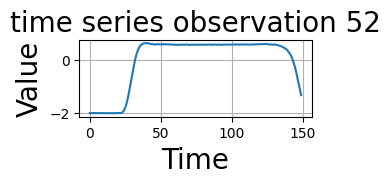

In [22]:
# plot observation 52 from times series
interval = np.arange(150)
val52 = df.loc[52]
label = "time series observation 52"
plot_time_series(interval, val52, label)

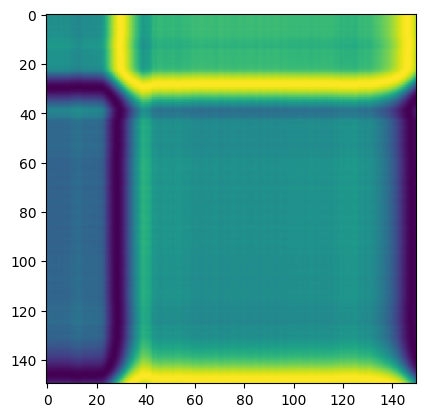

In [25]:
#observation 52 as GAF(sum) 
plt.imshow(x[52][1])

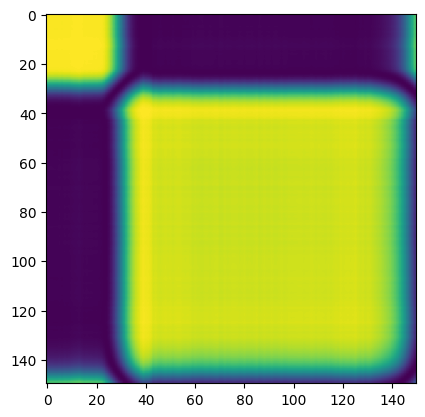

In [29]:
# observation 52 sa GAF(diff) dim=0 value is (52+200=252)
plt.imshow(x[252][0]) # value accros RGB channels tensor dim=1 is same for each observation

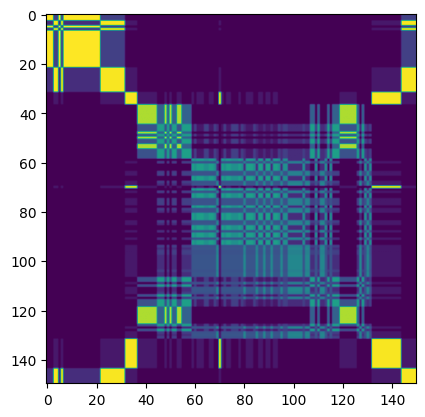

In [27]:
# observation 52 as MarcovTransitionField 
plt.imshow(x[452][1])

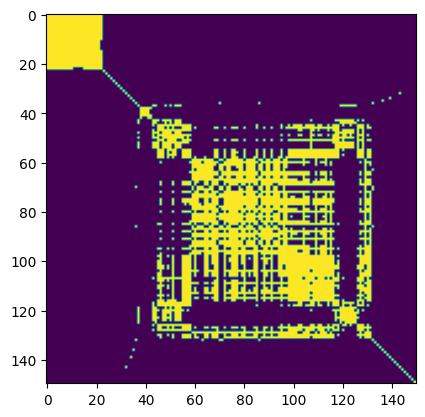

In [30]:
# observation 52 as RecurancePlt
plt.imshow(x[652][2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


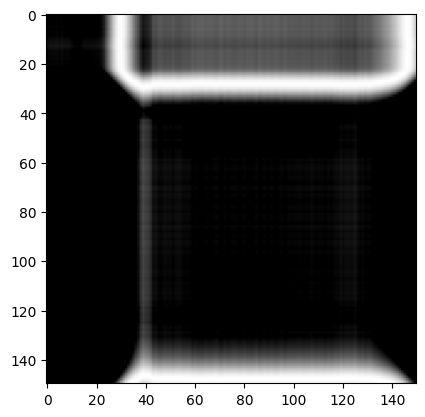

In [31]:
# plot of observation 52 across 3 channels GAF(sum)
plt.imshow(x[52].permute(1,2,0))

Export all images to directory and label them for CNN

In [32]:
Gun_NOgun = []
for o in y:
    if o==1.0:
        Gun_NOgun.append('GUN')
    else: Gun_NOgun.append('NO_GUN')

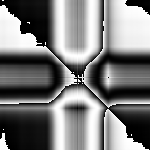

In [36]:
TO_PIL = transforms.ToPILImage()
img = TO_PIL(x[1])
img

In [38]:
# export images
path = Path("Images800")
for i,o in enumerate(Gun_NOgun):
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    image = TO_PIL(x[i])
    image.save(dest/f"{i}.jpg")
    # at this moment I manually removed one image from each class GUN (2.jpg) and NO_GUN(0.jpg)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


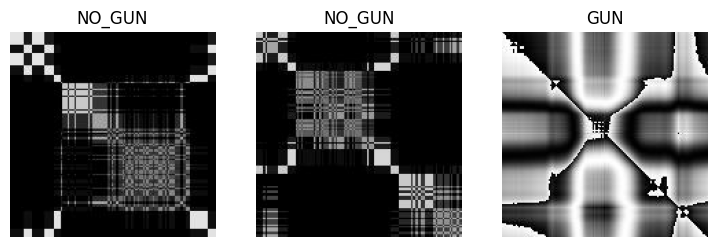

In [39]:
# set fastai data loaders (80 - 20 train val split)
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files,  
    splitter=RandomSplitter(valid_pct=0.2, seed=42), 
    get_y=parent_label, 
    item_tfms=None 
).dataloaders(path, bs=32)

dls.show_batch(max_n=3)

In [43]:
learn = vision_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(4)

c:\Users\mirko\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\mirko\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.640320,0.633207,0.100629,00:43


epoch,train_loss,valid_loss,error_rate,time
0,0.287468,0.277040,0.056604,00:56
1,0.269471,0.271443,0.050314,00:54
2,0.225864,0.304649,0.069182,01:27
3,0.166113,0.280566,0.050314,00:54


5% error rate 

In [47]:
gun_path = Path('2.jpg')
no_gun_path = Path('0.jpg')

In [48]:
# check predictions
categories = learn.dls.vocab
def predict(image):
    pred,idx,probs = learn.predict(image)
    return dict(zip(categories, map(float,probs)))


In [53]:
#one of images taken out b4 run it rought model 
gun = PILImage.create(gun_path)
no_gun = PILImage.create(no_gun_path)
predict(image=gun), predict(image=no_gun)

({'GUN': 1.0, 'NO_GUN': 1.1710295233502421e-10},
 {'GUN': 0.003978766966611147, 'NO_GUN': 0.9960212111473083})

Finding beter learning rate and Optimizing Model

c:\Users\mirko\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\mirko\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


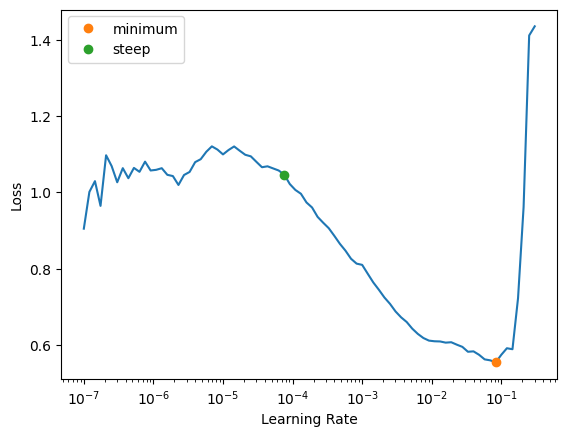

In [54]:
learn = vision_learner(dls, resnet50, metrics=error_rate)
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [56]:
lr_min, lr_steep

(0.00831763744354248, 7.585775892948732e-05)

c:\Users\mirko\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\mirko\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


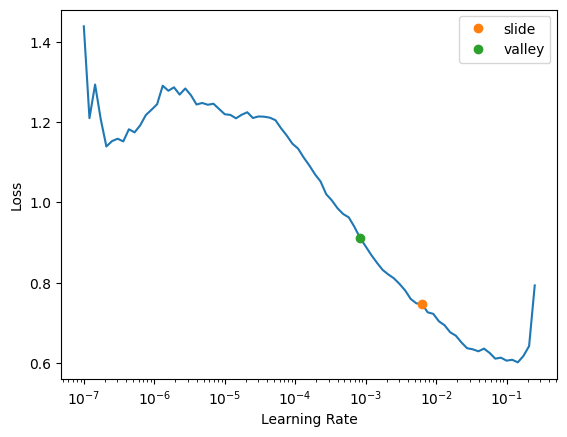

In [57]:
learn = vision_learner(dls, resnet50, metrics=error_rate)
lr_min,lr_steep = learn.lr_find(suggest_funcs=(slide, valley))

In [58]:
lr_min,lr_steep

(0.0063095735386013985, 0.0008317637839354575)

In [61]:
learn = vision_learner(dls, resnet50, metrics=error_rate) 
learn.fit_one_cycle(5, 8.3e-4)# run 5 epoch on last layer lr 0.00083
learn.unfreeze()
learn.fit_one_cycle(4, lr_max=slice(0.00001, 0.0005)) # 4 epoch across whole, with smaller lr over first layers 

epoch,train_loss,valid_loss,error_rate,time
0,0.492743,0.788958,0.100629,00:42
1,0.320311,0.250210,0.100629,00:40
2,0.242660,0.118975,0.056604,00:40
3,0.159963,0.101828,0.025157,00:41
4,0.107898,0.096227,0.018868,00:40
5,0.071233,0.093941,0.018868,00:41


epoch,train_loss,valid_loss,error_rate,time
0,0.015853,0.076281,0.018868,00:54
1,0.018068,0.163563,0.056604,00:56
2,0.053799,0.083739,0.018868,00:55
3,0.045970,0.066726,0.025157,00:56
4,0.030996,0.039820,0.025157,00:56
5,0.021404,0.042701,0.018868,00:56
